In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/font-bnazanin/B-NAZANIN.TTF
/kaggle/input/snappfood/dev.csv
/kaggle/input/snappfood/train.csv
/kaggle/input/snappfood/test.csv


In [2]:
!pip3 install hazm
!pip3 install nltk

  Obtaining dependency information for hazm from https://files.pythonhosted.org/packages/91/8c/cc3d01c27681eb8223781ea162a23f9926647ce864eb601a19aee4bce0af/hazm-0.10.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 35.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.9 MB/s eta 0:00:00
  Obtaining dependency information for python-crfsuite<0.10.0,>=0.9.9 from https://files.pythonhosted.org/packages/38/1d/c475ba7d11e9735f00eb08e2f5315aa2e21c24cc85a0474c3fd425edef58/python_crfsuite-0.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into a

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import re
import nltk
from hazm import stopwords_list
from itertools import chain
from collections import Counter
import plotly.express as px

In [4]:
sns.set_style('whitegrid')
plt.set_cmap('Set2')
sns.set_palette('Set2')

<Figure size 640x480 with 0 Axes>

In [5]:
train_df = pd.read_csv('/kaggle/input/snappfood/train.csv', delimiter='\t', on_bad_lines='skip',  usecols=[1, 2, 3])
test_df = pd.read_csv('/kaggle/input/snappfood/test.csv', delimiter='\t', on_bad_lines='skip',  usecols=[1, 2, 3])
dev_df = pd.read_csv('/kaggle/input/snappfood/dev.csv', delimiter='\t', on_bad_lines='skip',  usecols=[1, 2, 3])

In [6]:
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"Dev Shape: {dev_df.shape}")

Train Shape: (56700, 3)
Test Shape: (7000, 3)
Dev Shape: (6300, 3)


In [7]:
train_df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


In [8]:
train_df.columns

Index(['comment', 'label', 'label_id'], dtype='object')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56700 entries, 0 to 56699
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   56700 non-null  object
 1   label     56700 non-null  object
 2   label_id  56700 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [10]:
train_df.describe()

,label_id
count,56700.000000
mean,0.500000
std,0.500004
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [11]:
train_df.isna().sum()

comment     0
label       0
label_id    0
dtype: int64

In [12]:
train_df.drop_duplicates(subset='comment', inplace=True)

In [13]:
datasets = {'Train': train_df, 'Dev': dev_df, 'Test': test_df}

In [14]:
def plot_label_distribution(df, dataset_type, ax):
    sns.countplot(x='label', data=df, ax=ax)
    ax.set_title(f"{dataset_type} dataset")
    ax.set_xlabel('Label')  
    ax.set_ylabel('Count')

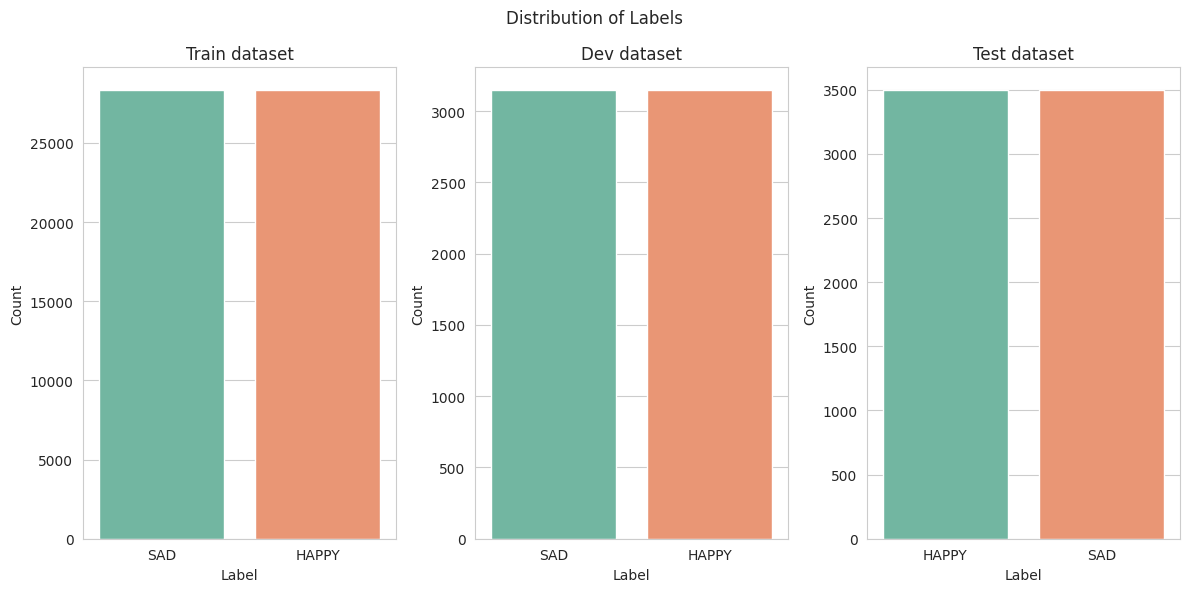

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for ax, (title, df) in zip(axes, datasets.items()):
    plot_label_distribution(df, title, ax)

fig.suptitle("Distribution of Labels")
plt.tight_layout()
plt.show()

In [16]:
def plot_label_pie_chart(df, dataset_type, ax):
    labels = df['label'].value_counts()
    ax.pie(labels, labels=labels.index, autopct='%.f%%')
    ax.set_title(f"{dataset_type} dataset")

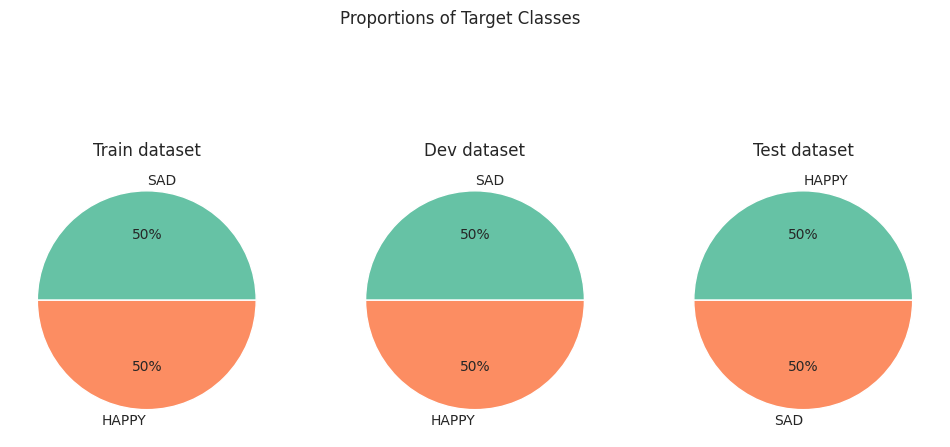

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for ax, (dataset_type, df) in zip(axes, datasets.items()):
    plot_label_pie_chart(df, dataset_type, ax)

fig.suptitle("Proportions of Target Classes")
plt.show()

In [18]:
train_df['cleaned_comment'] = train_df['comment'].apply(lambda x: re.sub(r'[^\w\s\u0600-\u06FF]', '', x))
train_df['tokens'] = train_df['cleaned_comment'].apply(word_tokenize)
train_df.head()

,comment,label,label_id,cleaned_comment,tokens
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,"[واقعا, حیف, وقت, که, بنویسم, سرویس, دهیتون, ش..."
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,"[قرار, بود, ۱, ساعته, برسه, ولی, نیم, ساعت, زو..."
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,"[قیمت, این, مدل, اصلا, با, کیفیتش, سازگاری, ند..."
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,"[عالللی, بود, همه, چه, درست, و, به, اندازه, و,..."
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,شیرینی وانیلی فقط یک مدل بود,"[شیرینی, وانیلی, فقط, یک, مدل, بود]"


In [19]:
# Set of Persian stop words using hazm
stop_words = set(stopwords_list())
print(list(stop_words)[:20])

['می\u200cتوانند', 'مواجه', 'مانند', 'روند', 'علاوه', 'بدون', 'بود', 'روی', 'بخشی', 'بزرگ', 'است', 'گاه', 'باشد', 'افزود', 'دارای', 'باشند', 'کند', 'بالا', 'محسوب', 'بوده']


In [20]:
train_df['tokens'] = train_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

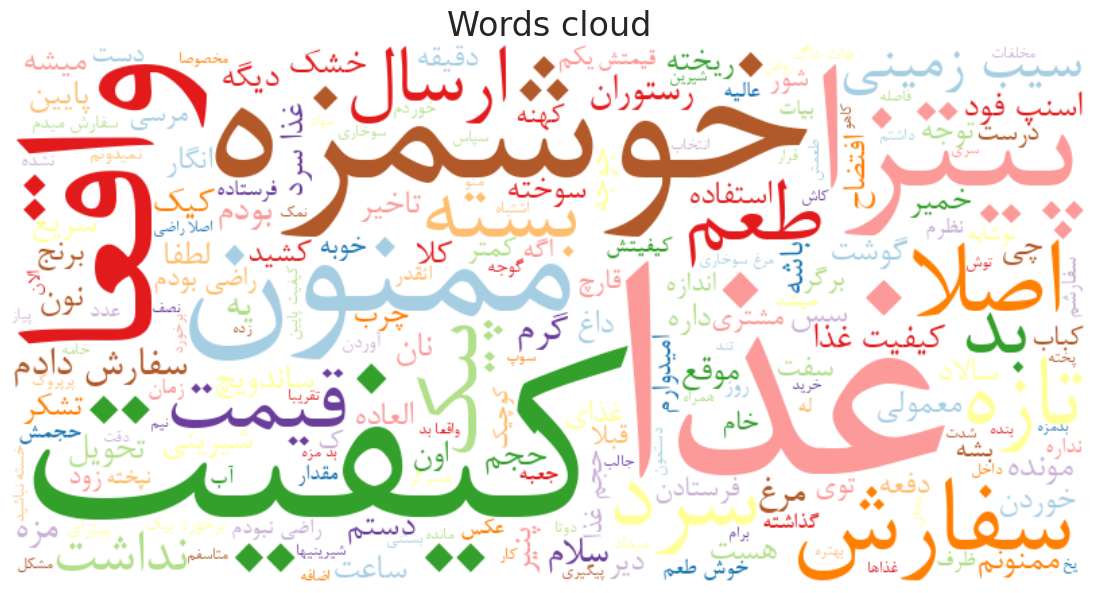

In [21]:

persian_font = '/kaggle/input/font-bnazanin/B-NAZANIN.TTF'
combined_text = " ".join(comment for comment in train_df['cleaned_comment'])

# Generate the word cloud considering Persian specifics
wordcloud = WordCloud(
    font_path=persian_font,
    width=800,
    height=400,
    background_color="white",
    colormap='Paired',
    stopwords=stop_words
).generate(combined_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words cloud', fontsize=24)
plt.show()

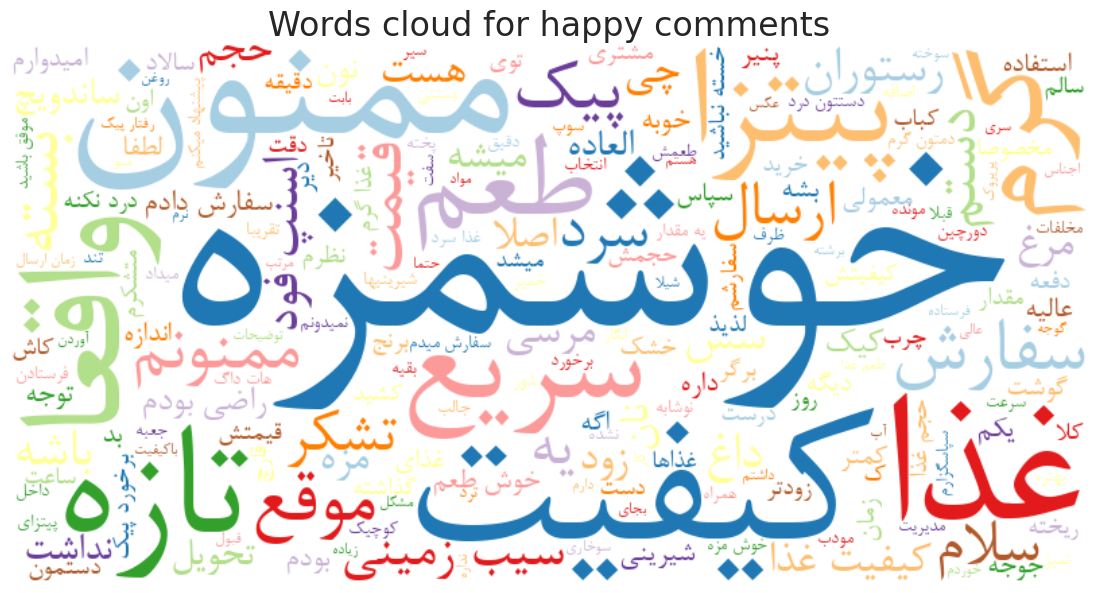

In [41]:

persian_font = '/kaggle/input/font-bnazanin/B-NAZANIN.TTF'
combined_text = " ".join(comment for comment in train_df[train_df['label'] == "HAPPY"]['cleaned_comment'])

# Generate the word cloud considering Persian specifics
wordcloud = WordCloud(
    font_path=persian_font,
    width=800,
    height=400,
    background_color="white",
    colormap='Paired',
    stopwords=stop_words
).generate(combined_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words cloud for happy comments', fontsize=24)
plt.show()

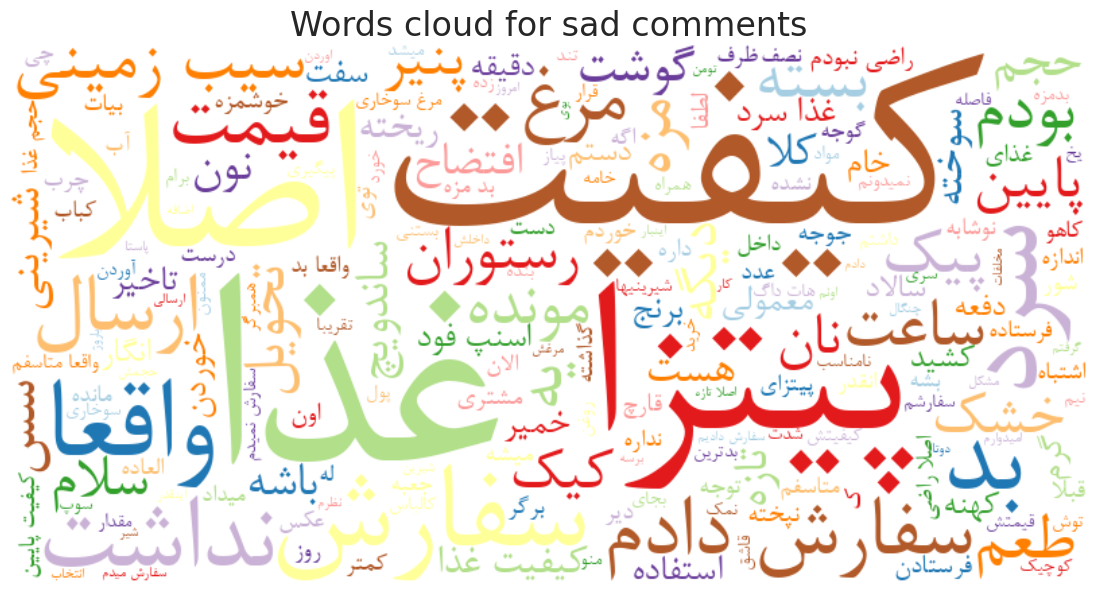

In [43]:

persian_font = '/kaggle/input/font-bnazanin/B-NAZANIN.TTF'
combined_text = " ".join(comment for comment in train_df[train_df['label'] == "SAD"]['cleaned_comment'])

# Generate the word cloud considering Persian specifics
wordcloud = WordCloud(
    font_path=persian_font,
    width=800,
    height=400,
    background_color="white",
    colormap='Paired',
    stopwords=stop_words
).generate(combined_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words cloud for sad comments', fontsize=24)
plt.show()

In [24]:
train_df['comment_length'] = train_df['cleaned_comment'].apply(len)

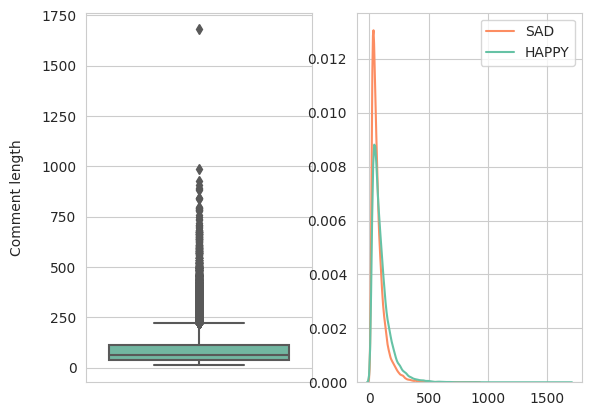

In [25]:
plt.subplot(1,2,1)

sns.boxplot(y=train_df['comment_length'], hue=train_df['label'])
plt.ylabel('Comment length', labelpad=12.5)

plt.subplot(1,2,2)
sns.kdeplot(data=train_df, x='comment_length', hue='label', common_norm=False)
plt.legend(train_df['label'].unique())
plt.xlabel('')
plt.ylabel('')

plt.show()

In [26]:
print(f"Mean length of happy comments: {train_df[train_df['label'] == 'HAPPY']['comment_length'].mean()}")
print(f"Mean length of sad comments: {train_df[train_df['label'] == 'SAD']['comment_length'].mean()}")

Mean length of happy comments: 75.90924162257495
Mean length of sad comments: 100.58514991181657


In [27]:
train_df['word_count'] = train_df['cleaned_comment'].apply(lambda x:len(str(x).split()))

In [28]:
train_df.head()

,comment,label,label_id,cleaned_comment,tokens,comment_length,word_count
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,"[واقعا, حیف, وقت, بنویسم, سرویس, دهیتون, افتضاح]",47,9
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,"[قرار, ۱, ساعته, برسه, نیم, ساعت, زودتر, موقع,...",146,26
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,"[قیمت, مدل, اصلا, کیفیتش, سازگاری, نداره،, ظاه...",89,17
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,"[عالللی, درست, اندازه, کیفیت, خوب،, امیداورم, ...",101,20
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,شیرینی وانیلی فقط یک مدل بود,"[شیرینی, وانیلی, مدل]",28,6


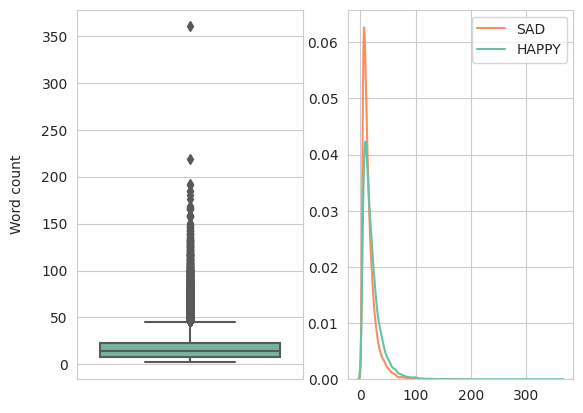

In [29]:
plt.subplot(1,2,1)

sns.boxplot(y=train_df['word_count'], hue=train_df['label'])
plt.ylabel('Word count', labelpad=12.5)

plt.subplot(1,2,2)
sns.kdeplot(data=train_df, x='word_count', hue='label', common_norm=False)
plt.legend(train_df['label'].unique())
plt.xlabel('')
plt.ylabel('')

plt.show()

In [30]:
print(f"Mean word count for happy comments: {train_df[train_df['label'] == 'HAPPY']['word_count'].mean()}")
print(f"Mean word count for sad comments: {train_df[train_df['label'] == 'SAD']['word_count'].mean()}")

Mean word count for happy comments: 15.972627865961199
Mean word count for sad comments: 21.123527336860672


In [31]:
all_words = [word for tokens_list in train_df['tokens'] for word in tokens_list]

word_counter = Counter(all_words)
most_common_words = word_counter.most_common()

# Print the 20 most common words
common_words = pd.DataFrame(most_common_words[:20])
common_words.columns = ['common_words','count']
common_words.style.background_gradient(cmap='Blues')

,common_words,count
0,غذا,12397
1,کیفیت,11342
2,سفارش,9142
3,پیتزا,6259
4,واقعا,5671
5,اصلا,5407
6,سرد,5338
7,خوشمزه,4641
8,ارسال,4546
9,طعم,4127


In [32]:
fig = px.bar(common_words, x="count", y="common_words", title='Top 20 most Commmon Words', orientation='h', 
             width=700, height=700,color='common_words')
fig.show()

In [33]:
fig = px.treemap(common_words, path=['common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [34]:
all_words = [word for tokens_list in train_df[train_df['label'] == 'HAPPY']['tokens'] for word in tokens_list]

word_counter = Counter(all_words)
most_common_words = word_counter.most_common()

# Print the 20 most common words in happy comments
common_happy_words = pd.DataFrame(most_common_words[:20])
common_happy_words.columns = ['common_words','count']
common_happy_words.style.background_gradient(cmap='Blues')

,common_words,count
0,غذا,5058
1,کیفیت,4963
2,خوشمزه,4059
3,ممنون,3742
4,سفارش,2841
5,تازه,2511
6,واقعا,2314
7,پیتزا,2262
8,طعم,2229
9,پیک,2154


In [35]:
fig = px.bar(common_happy_words, x="count", y="common_words", title='Top 20 most Commmon Words in happy comments', orientation='h', 
             width=700, height=700,color='common_words')
fig.show()

In [36]:
fig = px.treemap(common_happy_words, path=['common_words'], values='count',title='Tree of Most Common Words in happy comments')
fig.show()

In [37]:
all_words = [word for tokens_list in train_df[train_df['label'] == 'SAD']['tokens'] for word in tokens_list]

word_counter = Counter(all_words)
most_common_words = word_counter.most_common()

# Print the 20 most common words in sad comments
common_sad_words = pd.DataFrame(most_common_words[:20])
common_sad_words.columns = ['common_words','count']
common_sad_words.style.background_gradient(cmap='Blues')

,common_words,count
0,غذا,7339
1,کیفیت,6379
2,سفارش,6301
3,اصلا,4628
4,سرد,4056
5,پیتزا,3997
6,واقعا,3357
7,بد,3326
8,مرغ,2745
9,ارسال,2577


In [38]:
fig = px.bar(common_sad_words, x="count", y="common_words", title='Top 20 most Commmon Words in sad comments', orientation='h', 
             width=700, height=700,color='common_words')
fig.show()

In [39]:
fig = px.treemap(common_sad_words, path=['common_words'], values='count',title='Tree of Most Common Words in sad comments')
fig.show()

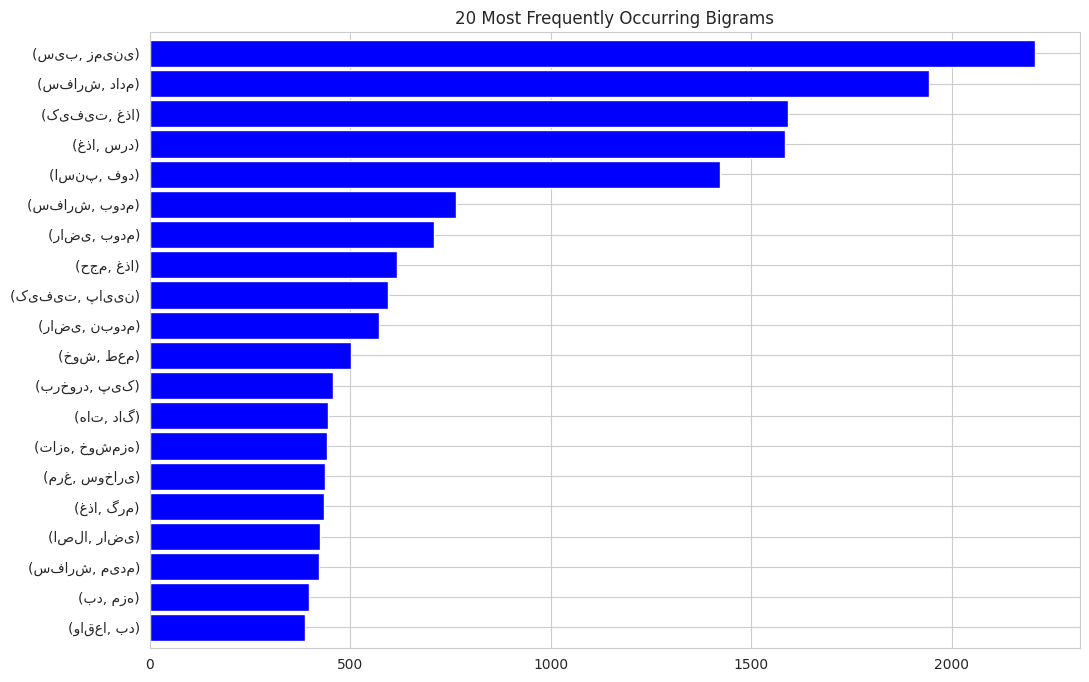

In [40]:
tokens_chain = chain.from_iterable(train_df['tokens'])

# Generate bigrams
bigrams = nltk.ngrams(tokens_chain, 2)

# Use a Counter for efficient counting
bigram_counts = nltk.FreqDist(bigrams)

# Get the 20 most common bigrams
bigrams_series = pd.Series(dict(bigram_counts.most_common(20)))

bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occurring Bigrams')
plt.show()